In [78]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scipy
import scipy.optimize

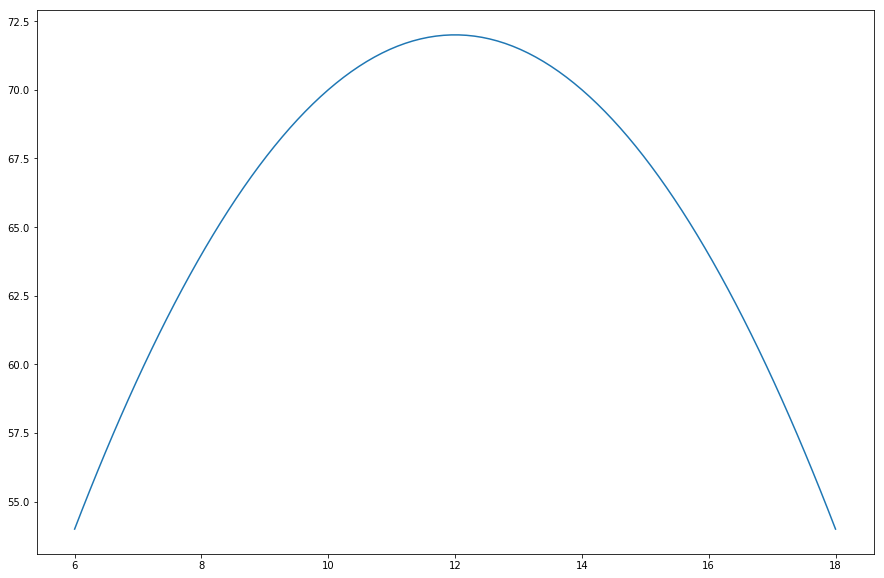

x tensor([12.0000], grad_fn=<AddBackward>)
y tensor([6.0000], requires_grad=True)
area tensor([72.], grad_fn=<ThMulBackward>)
perimeter tensor([24.], grad_fn=<ThAddBackward>)
x tensor([12.0043], requires_grad=True)
y tensor([5.9986], requires_grad=True)
area tensor([72.0087], grad_fn=<ThMulBackward>)
perimeter tensor([24.0014], grad_fn=<ThAddBackward>)
x tensor([12.0005], requires_grad=True)
y tensor([5.9995], requires_grad=True)
area tensor([71.9973], grad_fn=<ThMulBackward>)
perimeter tensor([23.9996], grad_fn=<ThAddBackward>)


In [109]:
"""
A farmer has a fence of size 24 and must fence a terrain alongside a line that represents a river:

                   x
        +---------------------+
        |                     |
     y  |       Terrain       |
        |                     |
****************************************
                 RIVER

What is the maximum amount of terrain he can protect?

Formulate the equation:
* maximize x * y
* given perimeter = 2 * y + x = 24
"""

"""
Solve it using simple calculus

y = 12 - x/2
=> maximize x * (12 - x/2)
=> maximize - x ** 2 / 2 + 12 * x

Take the derivate and search for point = 0
=> 12 - x = 0 => x = 12

Check that it is a maximum (via second derivative):
=> -1 < 0 so it is a maximum

=> x = 12 and y = 6
=> area = 73

Trace the plot:
"""

fig, ax = plt.subplots(figsize=(15, 10))
xs = np.linspace(6, 18, 100)
ax.plot(xs, - xs ** 2 / 2 + 12 * xs)
plt.show()


"""
Solving it using Lagrange multipliers

grad (x * y) = a * grad (2 * y + x - 24)

=> y = a (partial by x)
   x = 2 a (partial by y) = 2 * y
   2 * y + x = 24

=> 4 * y = 24 => y = 6 and x = 12
"""

"""
Solving it using Lagrangian

We are looking for grad (x * y) = a * grad (2 * y + x - 24)

So basically, we are trying to find the critical points (where grad = 0) of the function:
L(x, y, a) = f(x, y) - a * g(x, y)
L(x, y, a) = (x * y) - a * (2 * y + x - 24)

=> y - a = 0
   x - 2 * a = 0
   2 * y + x - 24 = 0

=> 4 * y = 24 => y = 6 and x = 12 (same as for Lagrange multipliers)

The difference is that it will lead to another formulation for OPTIMIZERS.
"""

"""
Solve it using overkill: Pytorch
(formulating things in terms of variable replacement)
"""

y_val = torch.tensor([1.], requires_grad=True)
y = nn.parameter.Parameter(y_val)

optimizer = optim.Adam([y], lr=1e-2)
for _ in range(5000):
    x = 24 - 2 * y
    neg_area = -1 * x * y
    optimizer.zero_grad()
    neg_area.backward()
    optimizer.step()

print("x", x)
print("y", y_val)
print("area", x * y)
print("perimeter", x + 2 * y)


"""
Solve it using overkill: Pytorch
(formulating things in terms of SOFT constraints)
"""

x_val = torch.tensor([22.], requires_grad=True)
y_val = torch.tensor([1.], requires_grad=True)
x = nn.parameter.Parameter(x_val)
y = nn.parameter.Parameter(y_val)

def perimeter_diff_loss(perimeter):
    # The higher the loss, the more we respect the constraint
    # But if the loss is too high, we stay stuck (cannot move?)
    return 2000 * (perimeter - 24) ** 2

optimizer = optim.Adam([x, y], lr=1e-2)
for _ in range(5000):
    area = x * y
    perimeter = x + 2 * y
    q = - area + perimeter_diff_loss(perimeter)
    optimizer.zero_grad()
    q.backward()
    optimizer.step()

print("x", x_val)
print("y", y_val)
print("area", x * y)
print("perimeter", x + 2 * y)


"""
Solve it using overkill: Pytorch
Formulating things in terms of LAGRANGIAN (HARD constraints)

But:
- We are still doing the symbolic differentiation by hand...
- We are basically doing a gradient descent on the derivative to find ONE critical point :(
"""

x_val = torch.tensor([22.], requires_grad=True)
y_val = torch.tensor([1.], requires_grad=True)
a_val = torch.tensor([1.], requires_grad=True)
x = nn.parameter.Parameter(x_val)
y = nn.parameter.Parameter(y_val)
a = nn.parameter.Parameter(a_val)

optimizer = optim.Adam([x, y, a], lr=1e-2)
for _ in range(5000):
    dx = y - a
    dy = x - 2 * a
    da = 2 * y + x - 24
    q = dx ** 2 + dy ** 2 + da ** 2
    optimizer.zero_grad()
    q.backward()
    optimizer.step()

print("x", x_val)
print("y", y_val)
print("area", x * y)
print("perimeter", x + 2 * y)

x tensor([1.7318], requires_grad=True)
y tensor([1.7318], requires_grad=True)
distance squared tensor([5.9980], grad_fn=<ThAddBackward>)


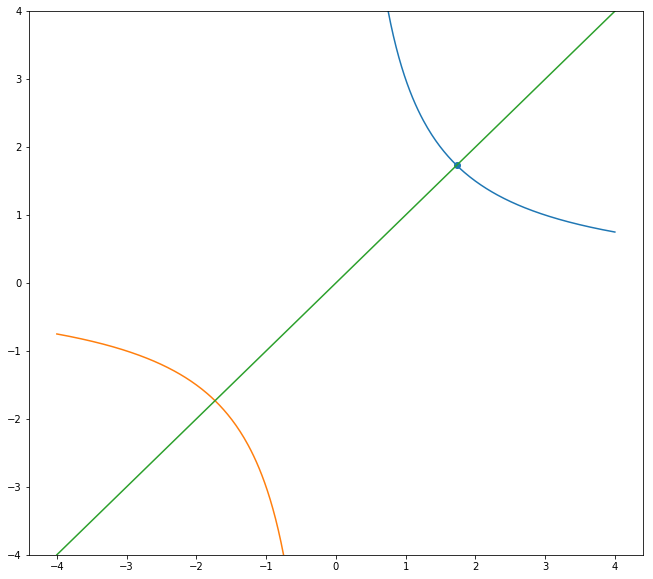

In [104]:
"""
Find the point the closest on the surface x * y = 3 to the origin.

In other terms:
* minimize x ** 2 + y ** 2
* such that x * y = 3
"""


"""
Doing it with PyTorch
"""

x_val = torch.tensor([1.], requires_grad=True)
y_val = torch.tensor([1.], requires_grad=True)

x = nn.parameter.Parameter(x_val)
y = nn.parameter.Parameter(y_val)

optimizer = optim.Adam([x, y], lr=1e-2)
for _ in range(5000):
    q = x ** 2 + y ** 2 + 1000 * (x * y - 3) ** 2
    optimizer.zero_grad()
    q.backward()
    optimizer.step()

print("x", x_val)
print("y", y_val)
print("distance squared", x ** 2 + y ** 2)


"""
Solving it using Lagrange multipliers

grad (x ** 2 + y ** 2) = a * grad (x * y - 3)

=> 2 * x = a * y              (partial by x)
   2 * y = a * x              (partial by y)
   x * y = 3

=> x = a * y / 2
   y = a * x / 2

=> y = a * (a * y / 2) / 2
   y = a ** 2 * y / 4
   y = 0 or 1 = a ** 2 / 4
   but y = 0 is not possible because of x * y = 3

=> a = +- sqrt(4) = +- 2
   but a negative is not possible cause x and y must have the same sign due to x * y = 3

=> a = 2
=> x = y
=> x = y = += sqrt(3)
"""

fig, ax = plt.subplots(figsize=(11, 10))
xs = np.linspace(0.1, 4, 200)
ax.plot(xs, 3 / xs)
ax.plot(-xs, 3 / (-xs))
ax.scatter(x_val.detach().numpy(), y_val.detach().numpy())
ax.set_ylim((-4, 4))
ax.plot([-4, 4], [-4, 4])
plt.show()

x tensor([1.4013e-44], requires_grad=True)
y tensor([1.4013e-44], requires_grad=True)
z tensor([-0.0000], requires_grad=True)
distance tensor([0.], grad_fn=<ThAddBackward>)


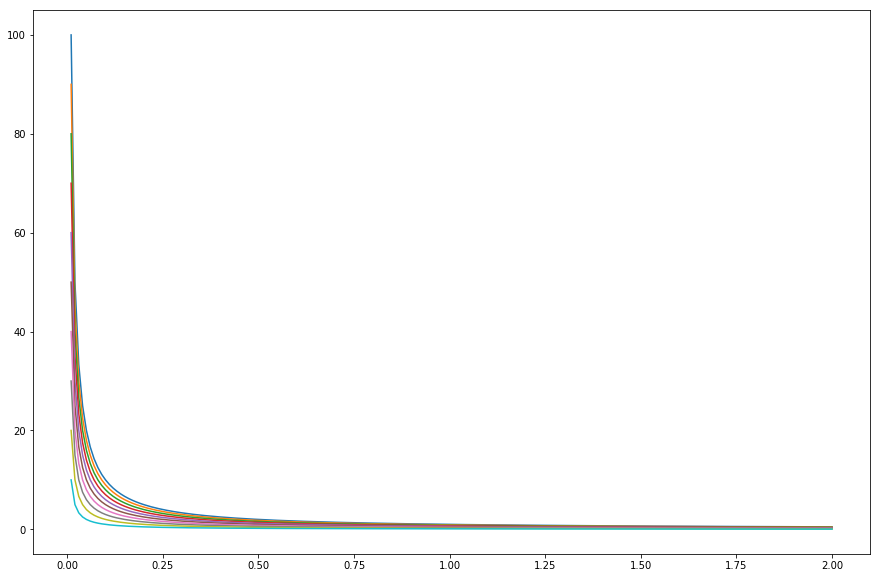

     fun: 7.979616297903035e-12
     jac: array([ 0.00055368,  0.00055368, -0.00026067])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([-1.99648801e-06, -1.99689963e-06, -7.77418341e-08])


In [82]:
"""
Find the point the closest on the surface x * y = z to the origin.

In other terms:
* minimize x ** 2 + y ** 2 + z ** 2
* such that x * y = z
"""

"""
Solve it using overkill: Pytorch
(formulating things in terms of constraints)
"""

x_val = torch.tensor([1.], requires_grad=True)
y_val = torch.tensor([1.], requires_grad=True)
z_val = torch.tensor([1.], requires_grad=True)

x = nn.parameter.Parameter(x_val)
y = nn.parameter.Parameter(y_val)
z = nn.parameter.Parameter(z_val)

optimizer = optim.Adam([x, y, z], lr=1e-2)
for _ in range(5000):
    q = x ** 2 + y ** 2 + z ** 2 + (x * y - z) ** 2
    optimizer.zero_grad()
    q.backward()
    optimizer.step()

print("x", x_val)
print("y", y_val)
print("z", z_val)
print("distance", x ** 2 + y ** 2 + z ** 2)

"""
Solving it using Lagrange multipliers

grad (x ** 2 + y ** 2 + z ** 2) = a * grad (x * y / z)

=> 2 * x = a * y / z              (partial by x)
   2 * y = a * x / z              (partial by y)
   2 * z = a * - x * y / z ** 2   (partial by z)
   x * y = z

=> 2 * z = - a / z                (replace x * y = z in partial by z)
=> z ** 2 = - a / 2
=> a = 0 (no real gradient)

=> the thing is that the curve is not really defined for z = 0
(we know that y = 0 everywhere when x != 0, but undefined in x = 0)

Showing the successive plots with decreasing z:
"""

fig, ax = plt.subplots(figsize=(15, 10))
xs = np.linspace(0.01, 2, 200)
for z in reversed(np.linspace(0.1, 1, 10)):
    ax.plot(xs, z / xs)
plt.show()


"""
Solving it with scipy
"""

def distance_to_origin(xs):
    xs = np.array(xs)
    return np.dot(xs, xs)

contraints = ({'type': 'eq', 'fun': lambda xs: xs[0] * xs[1] - xs[2]})
res = scipy.optimize.minimize(distance_to_origin, [1, 1, 1], constraints=contraints)
print(res)